#### Librerías

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.12.0


## Datos

In [16]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/home/willy98/archivos/Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:
    ruta_list = ruta.split('/')
    clase = ruta_list[7]
    number = ruta_list[8]
    tipo = ruta_list[9]
    name = ruta_list[10].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','class','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','class','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','class','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['class'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 927
MF1: - secas:  378
MF2: - secas:  288
MF3: - secas:  261


,name,route_image,class,number,route_mask
9,IMG_20230601_151844_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...
194,IMG_20230707_164622_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
794,IMG_20230711_211511_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
805,IMG_20230711_212106_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,7,/home/willy98/archivos/Datasets/Micrografías_s...
587,IMG_20230711_163540_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,3,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
85,IMG_20230602_221637_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,4,/home/willy98/archivos/Datasets/Micrografías_s...
140,IMG_20230707_162326_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
184,IMG_20230707_164443_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
631,IMG_20230711_170043_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,1,4,/home/willy98/archivos/Datasets/Micrografías_s...


In [17]:
## Establecer el porcentaje de separación
prct_train = 0.8

thold1 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='0'])))
thold2 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='1'])))
thold3 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset['class'] == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset['class'] == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset['class'] == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset['class'] == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset['class'] == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset['class'] == '2'][thold3:]

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  231 , test:  57
Clase MF3: train:  209 , test:  52


In [18]:
### Definir datasets de training y test
# Todas las clases
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

# solo una clase
#train_df = train_cu1
#test_df = test_cu1

train_df

,name,route_image,class,number,route_mask
194,IMG_20230707_164622_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
111,IMG_20230707_161912_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
234,IMG_20230707_171018_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...
276,IMG_20230707_173802_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
446,IMG_20230707_191527_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,7,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
919,IMG_20230711_223017_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,5,/home/willy98/archivos/Datasets/Micrografías_s...
46,IMG_20230602_212033_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,3,/home/willy98/archivos/Datasets/Micrografías_s...
839,IMG_20230711_212807_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,7,/home/willy98/archivos/Datasets/Micrografías_s...
880,IMG_20230711_215030_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,6,/home/willy98/archivos/Datasets/Micrografías_s...


In [19]:
## Crear objetos transformadores
## Para entrenamiento
SEED = 100

img_generator_images = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

img_generator_mask = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator_IMAGES = img_generator_images.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_image",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

train_generator_MASK = img_generator_mask.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_mask",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 595 validated image filenames belonging to 3 classes.
Found 595 validated image filenames belonging to 3 classes.


In [20]:
X_train_images = []
train_mask = []
label_train_images  = []
label_train_mask = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator_IMAGES.next()

    X_train_images.extend(x)
    label_train_images.extend(y)
    
for i in range(batches):
    
    x,y = train_generator_MASK.next()

    train_mask.extend(x)
    label_train_mask.extend(y)
    
    
print(np.shape(train_mask),np.shape(train_mask))
print(np.array_equal(label_train_mask,label_train_images))

(2975, 128, 128, 1) (2975, 128, 128, 1)
True


1.0 1.0


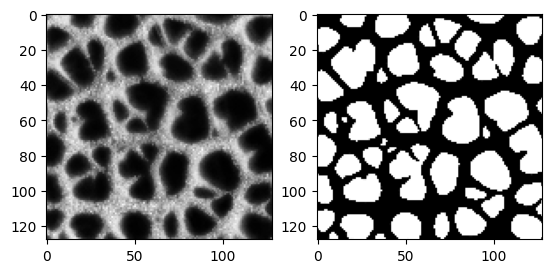

In [21]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(train_mask[n],cmap='gray')
ax1.imshow(X_train_images[n],cmap='gray')
print(label_train_mask[n],label_train_images[n])
plt.show()

In [22]:
## Dataset de prueba
test_df_shuffled = test_df.sample(frac=1,random_state=42).reset_index(drop=True)

X_test_images = []
y_test_images = []
X_test_mask = []
y_test_mask = []

nsize = 128

## Recorrerr rutas
for i in range(len(test_df_shuffled)):
    
    #Capturar ruta y label
    ruta_img = test_df_shuffled.iloc[i].route_image
    label_img = test_df_shuffled.iloc[i]['class']
    ruta_mask = test_df_shuffled.iloc[i].route_mask
    label_mask = test_df_shuffled.iloc[i]['class']
    
    ##cargar imagen
    im = tf.keras.preprocessing.image.load_img(ruta_img,color_mode='grayscale')
    msk = tf.keras.preprocessing.image.load_img(ruta_mask,color_mode='grayscale')
    
    X_test_images.append(tf.keras.preprocessing.image.img_to_array(im.resize((nsize,nsize))))
    y_test_images.append(label_img)
    
    X_test_mask.append(tf.keras.preprocessing.image.img_to_array(msk.resize((nsize,nsize))))
    y_test_mask.append(label_mask)
    
print('Test: images->',np.shape(X_test_images),' label ->',np.shape(y_test_images))
print('Test: mask->',np.shape(X_test_mask),' label ->',np.shape(y_test_mask))

Test: images-> (184, 128, 128, 1)  label -> (184,)
Test: mask-> (184, 128, 128, 1)  label -> (184,)


In [23]:
x_train_images = np.array(X_train_images)
x_test_images = np.array(X_test_images)

x_train_images = x_train_images.astype('float32')
x_test_images= x_test_images.astype('float32')
 
#y_test_images = tf.keras.utils.to_categorical(y_test_images)
#y_train_expanded = tf.keras.utils.to_categorical(y_train_expanded) 

#x_train_expanded /= 255
x_test_images /= 255

print('x_train shape:', x_train_images.shape)
print('Number of images in x_train', x_train_images.shape, "y_train:", np.shape(label_train_images))
print('Number of images in x_test', x_test_images.shape, "y_test: ", np.shape(y_test_images))

x_train shape: (2975, 128, 128, 1)
Number of images in x_train (2975, 128, 128, 1) y_train: (2975,)
Number of images in x_test (184, 128, 128, 1) y_test:  (184,)


0 0


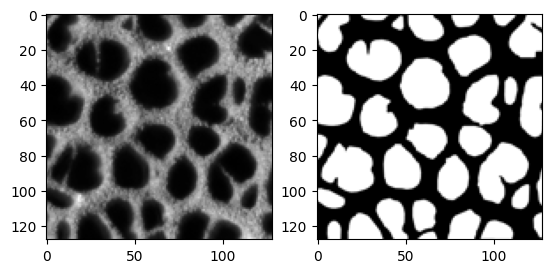

In [24]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(X_test_mask[n],cmap='gray')
ax1.imshow(X_test_images[n],cmap='gray')
print(y_test_mask[n],y_test_mask[n])
plt.show()

## Cargar modelo

In [25]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [26]:
VAE_encoder = keras.models.load_model('Models/GVAE_DRY_MF1_128_1_encoder.h5', custom_objects={'Sampling':Sampling},compile=False)
VAE_decoder = keras.models.load_model('Models/GVAE_DRY_MF1_128_1_decoder.h5', custom_objects={'Sampling':Sampling},compile=False)

## PCA

In [27]:
data_train = x_train_images
data_test = x_test_images

label_train = label_train_images
label_test = y_test_images

# Embebidos del encoder
encoder_embds  = VAE_encoder.predict(data_train)
print('Shape_embs: ',np.shape(encoder_embds))

# Embebidos del encoder
encoder_embds_test  = VAE_encoder.predict(data_test)
print('Shape_embs: ',np.shape(encoder_embds_test))

93/93 [==============================] - 307s 3s/step
Shape_embs:  (3, 2975, 128)
6/6 [==============================] - 20s 3s/step
Shape_embs:  (3, 184, 128)


In [28]:
## Media = 0, Varianza = 1, Z = 2
D = 2

## Dimensiones
dmx = 16
dmy = 8

np.shape(encoder_embds[D])

(2975, 128)

In [29]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs = VAE_decoder.predict(encoder_embds[D])
print(np.shape(autoencoder_imgs),np.shape(encoder_embds[D]))

93/93 [==============================] - 5s 54ms/step
(2975, 128, 128, 1) (2975, 128)


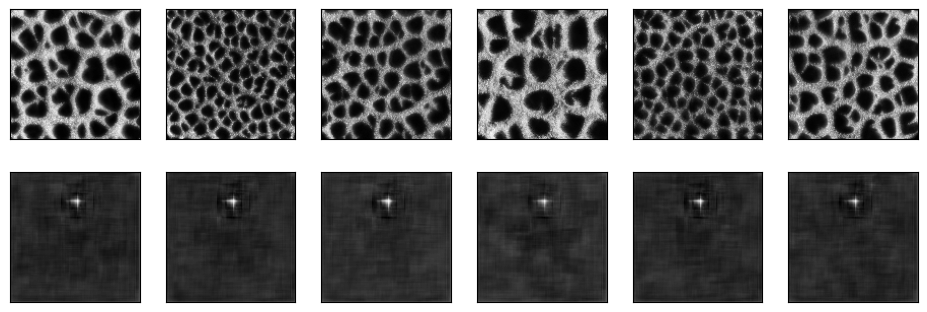

In [30]:
plt.figure(figsize=(80, 6))
for i in range(6):
    # display original
    ax = plt.subplot(3, 40, i + 1)
    plt.imshow(data_train[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)     
    
    
    # display reconstruction
    ax = plt.subplot(3, 40, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [31]:
# Imágenes del Decoder (from encoder embeddings)
autoencoder_imgs_test = VAE_decoder.predict(encoder_embds_test[D])
print(np.shape(autoencoder_imgs_test),np.shape(encoder_embds_test))

6/6 [==============================] - 0s 54ms/step
(184, 128, 128, 1) (3, 184, 128)


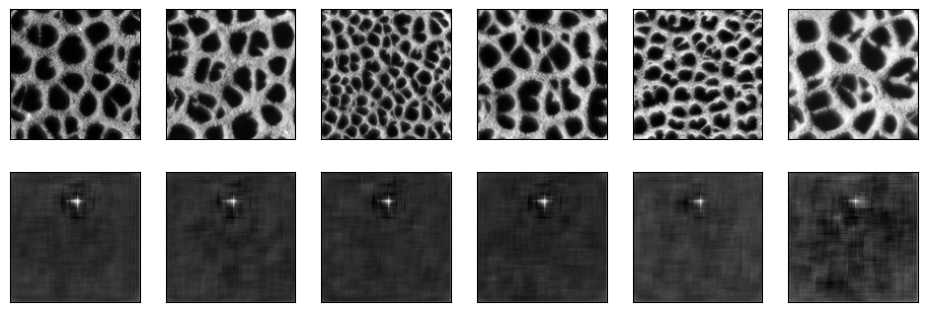

In [32]:
plt.figure(figsize=(80, 6))
for i in range(6):
    # display original
    ax = plt.subplot(3, 40, i + 1)
    plt.imshow(data_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    
    # display reconstruction
    ax = plt.subplot(3, 40, 2*20 +i+ 1)
    plt.imshow(autoencoder_imgs_test[i].reshape(128,128,1))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
plt.show()

In [33]:
pca_data = PCA(n_components=2)
PCA_2dim = pca_data.fit_transform(encoder_embds[D])
PCA_2dim.shape

(2975, 2)

In [34]:
labels_text = pd.DataFrame(label_train_images).replace({0: "MF1", 1: "MF2",2: "MF3"})
labels_text.shape

(2975, 1)

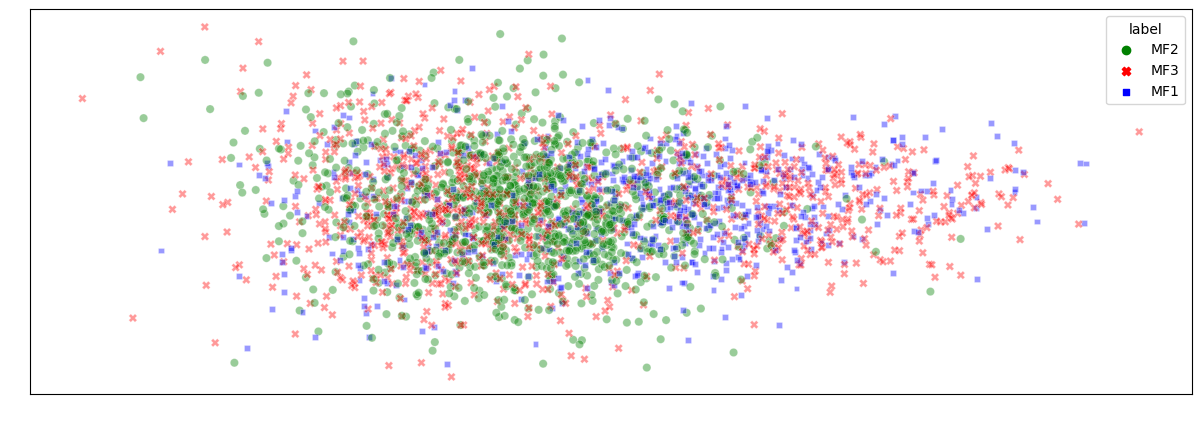

In [35]:
data_img = pd.DataFrame()                 
data_img['x'] = PCA_2dim[:,0]
data_img['y'] = PCA_2dim[:,1]
data_img['label'] = pd.DataFrame(labels_text)


plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img.x,y=data_img.y,hue='label',data=data_img, style='label',
            sizes=(60, 100), alpha=0.4, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
plt.xticks([])
plt.yticks([])
#plt.legend(fontsize="18")
#plt.xticks(range(-5, 5))
#plt.grid()

plt.show()

In [36]:
labels_text_test = pd.DataFrame(y_test_images).replace({'0': "MF1", '1': "MF2",'2': "MF3"})
labels_text_test.shape

(184, 1)

In [37]:
pca_data_test = PCA(n_components=2)
PCA_2dim_test = pca_data_test.fit_transform(encoder_embds_test[D])
PCA_2dim_test.shape

(184, 2)

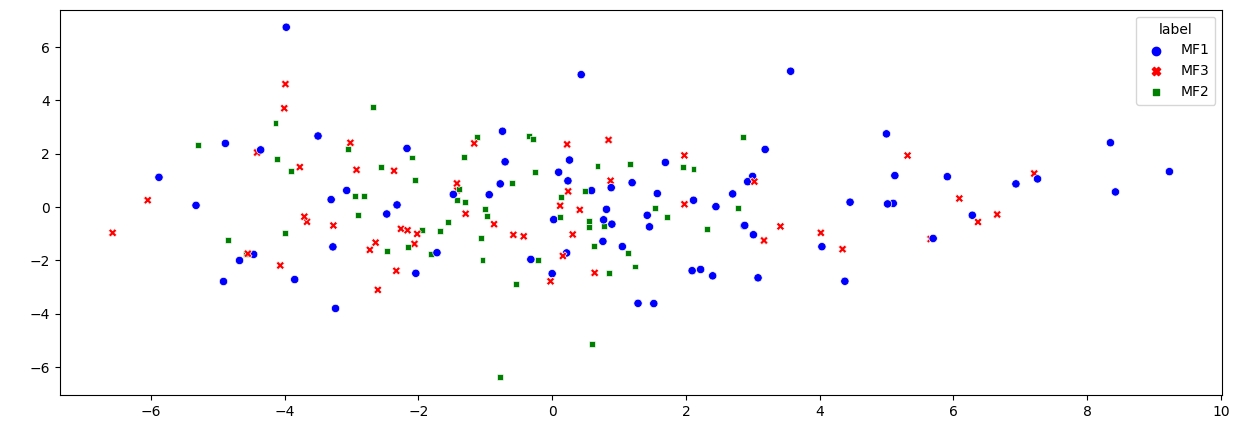

In [38]:
data_img_pca_test = pd.DataFrame()                 
data_img_pca_test['x'] = PCA_2dim_test[:,0]
data_img_pca_test['y'] = PCA_2dim_test[:,1]
data_img_pca_test['label'] = pd.DataFrame(labels_text_test)


sctter = plt.figure(figsize=(15,5))
sns.scatterplot(x=data_img_pca_test.x,y=data_img_pca_test.y,hue='label',data=data_img_pca_test,style='label',
            sizes=(60, 100), alpha=1, palette={"MF3": "red", "MF2": "green", "MF1": "blue"},
                legend=True)
plt.xlabel(' ')
plt.ylabel(' ')
#plt.xticks([])
#plt.yticks([])
plt.show()